# Imports


In [5]:
from pydantic import BaseModel, Field

from qdrant_client import QdrantClient
from qdrant_client.models import Prefetch, FusionQuery, Document


from langsmith import traceable

from langgraph.graph import StateGraph, START, END
from langgraph.types import Send


from jinja2 import Template
from typing import Annotated, List
from operator import add
from openai import OpenAI

import openai

import instructor

In [6]:
class State(BaseModel):
    expanded_query: List[str] = []
    retrieved_context: Annotated[List[str], add] = []
    question_relevant: bool = False
    initial_query: str = ""
    answer: str = ""
    query: str = ""
    k: int = 10

In [7]:
class QueryExpandResponse(BaseModel):
    expanded_query: List[str]

In [8]:
@traceable(
    name="agent_node",
    run_type="llm",
    metadata={"ls_provider": "openai", "ls_model_name": "gpt-4.1-mini"},
)
def query_expand_node(state: State):
    prompt_template = """You are part of a shopping assistant that can answer questions about products in stock.

Instructions:
- You will be given a question and you need to expand it into a list statements that can be used in contextual search to retrieve relevant products.
- The statements should not overlap in context. Single item should not be expanded into multiple statements unless it is specifically mentioned in several contexts.

<Question>
{{ query }}
</Question>
"""

    template = Template(prompt_template)

    prompt = template.render(query=state.initial_query)

    client = instructor.from_openai(OpenAI())

    response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4.1-mini",
        response_model=QueryExpandResponse,
        messages=[{"role": "system", "content": prompt}],
        temperature=0.5,
    )

    return {"expanded_query": response.expanded_query}

In [9]:
def query_expand_conditional_edges(state: State):
    send_messages = []

    for query in state.expanded_query:
        send_messages.append(Send("retrieve_node", {"query": query, "k": 10}))

    return send_messages

In [10]:
@traceable(
    name="embed_query",
    run_type="embedding",
    metadata={"ls_provider": "openai", "ls_model_name": "text-embedding-3-small"},
)
def get_embedding(text, model="text-embedding-3-small"):
    response = openai.embeddings.create(
        input=[text],
        model=model,
    )

    return response.data[0].embedding


@traceable(name="retrieve_top_n", run_type="retriever")
def retrieve_node(state: State) -> dict:
    qdrant_client = QdrantClient(url="http://localhost:6333")

    query_embedding = get_embedding(state["query"])

    results = qdrant_client.query_points(
        collection_name="Amazon-items-collection-01-hybrid-search",
        prefetch=[
            Prefetch(query=query_embedding, using="text-embedding-3-small", limit=20),
            Prefetch(
                query=Document(text=state["query"], model="qdrant/bm25"),
                using="bm25",
                limit=20,
            ),
        ],
        query=FusionQuery(fusion="rrf"),
        limit=state["k"],
    )

    retrieved_context = []
    retrieved_context_ids = []
    retrieved_context_ratings = []

    for result in results.points:
        retrieved_context_ids.append(result.payload["parent_asin"])
        retrieved_context.append(result.payload["description"])
        retrieved_context_ratings.append(result.payload["average_rating"])

    formatted_context = ""

    for id, chunk, rating in zip(
        retrieved_context_ids, retrieved_context, retrieved_context_ratings
    ):
        formatted_context += f"- ID: {id}, rating: {rating}, description: {chunk}\n"

    return {
        "retrieved_context": [formatted_context],
    }

In [11]:
class AggregatorResponse(BaseModel):
    answer: str = Field(description="Answer to the question.")

In [12]:
@traceable(
    name="agent_node",
    run_type="llm",
    metadata={"ls_provider": "openai", "ls_model_name": "gpt-4.1-mini"},
)
def aggregator_node(state: State) -> dict:
    preprocessed_context = "\n".join(state.retrieved_context)

    prompt_template = """You are a shopping assistant that can answer questions about the products in stock.

You will be given a question and a list of context.

Instructions:
- You need to answer the question based on the provided context only.
- Never use word context and refer to it as the available products.
- The answer to the question should contain detailed information about the product and returned with detailed specification in bullet points.

Context:
{{ preprocessed_context }}

Question:
{{ question }}
"""

    template = Template(prompt_template)

    prompt = template.render(
        preprocessed_context=preprocessed_context, question=state.initial_query
    )

    client = instructor.from_openai(OpenAI())

    response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4.1-mini",
        response_model=AggregatorResponse,
        messages=[{"role": "system", "content": prompt}],
        temperature=0.5,
    )

    return {"answer": response.answer}

## User Intent Router

In [13]:
class IntentRouterResponse(BaseModel):
    question_relevant: bool
    answer: str

In [30]:
@traceable(
    name="agent_node",
    run_type="llm",
    metadata={"ls_provider": "openai", "ls_model_name": "gpt-4.1-mini"},
)
def intent_router_node(state: State):
    prompt_template = """You are part of a shopping assistant that can answer questions about products in stock.

Instructions:
- You will be given a question and you need to clasify it into relevant or not relevant.
- If the question is not relevant, return False in field "question_relevant" and set "answer" to explanation why it is not relevant.
- If the question is relevant, return True in field "question_relevant" and set "answer" to "".
- You should only answer questions about the products in stock. If the question is not about the products in stock, you should ask for clarification.

<Question>
{{ query }}
</Question>
"""

    template = Template(prompt_template)

    prompt = template.render(query=state.initial_query)

    client = instructor.from_openai(OpenAI())

    response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4.1-mini",
        response_model=IntentRouterResponse,
        messages=[{"role": "system", "content": prompt}],
        temperature=0.5,
    )

    return {"question_relevant": response.question_relevant, "answer": response.answer}

In [19]:
def intent_router_conditional_expand(state: State):
    if state.question_relevant:
        return "query_expand_node"
    else:
        return "end"

In [31]:
workflow = StateGraph(State)

workflow.add_node("query_expand_node", query_expand_node)
workflow.add_node("retrieve_node", retrieve_node)
workflow.add_node("aggregator_node", aggregator_node)
workflow.add_node("intent_router_node", intent_router_node)

workflow.add_edge(START, "intent_router_node")
workflow.add_conditional_edges("query_expand_node", query_expand_conditional_edges)
workflow.add_conditional_edges(
    "intent_router_node",
    intent_router_conditional_expand,
    {"query_expand_node": "query_expand_node", "end": END},
)

workflow.add_edge("retrieve_node", "aggregator_node")
workflow.add_edge("aggregator_node", END)

graph = workflow.compile()

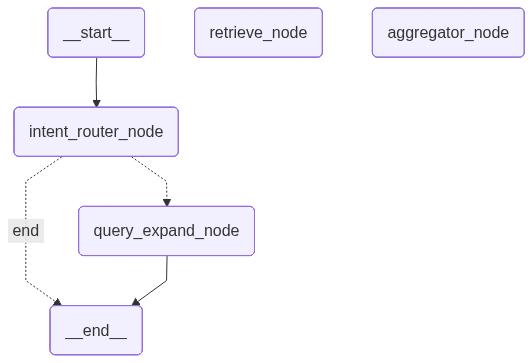

In [32]:
graph

In [33]:
initial_state = {"initial_query": "How's the weather today?"}

result = graph.invoke(initial_state)

In [34]:
result

{'retrieved_context': [],
 'question_relevant': False,
 'initial_query': "How's the weather today?",
 'answer': 'The question about the weather today is not relevant to the products in stock. Please ask about products or related information.'}